In [1]:
import sys
import numpy as np
import torch 
# still do preprocessing in scipy
import scipy.sparse as sp
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# import factor model from beta-dirichlet-factor
sys.path.append('/gpfs/commons/home/kisaev/Leaflet/src/beta-dirichlet-factor')
import factor_model

In [2]:
leaflet_repo = '/gpfs/commons/home/kisaev/Leaflet/src/beta-binomial-mix/'
sys.path.append(leaflet_repo)
import load_cluster_data
from betabinomo_mix_singlecells import *

### Settings and Load data

In [3]:
torch.manual_seed(42)

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

float_type = { 
    "device" : device, 
    "dtype" : torch.float, # save memory
}

cpu


In [4]:
input_files_folder = '/gpfs/commons/groups/knowles_lab/Karin/Leaflet-analysis-WD/TabulaMurisBrain/MLCB_Brain_true/FULL/'
cell_types = ['Brain_Non-Myeloid_brain_pericyte',
 'Brain_Non-Myeloid_oligodendrocyte_precursor_cell',
 'Brain_Non-Myeloid_endothelial_cell' 'Brain_Non-Myeloid_oligodendrocyte',
 'Brain_Non-Myeloid_neuron', 'Brain_Myeloid_macrophage',
 'Brain_Myeloid_microglial_cell', 'Brain_Non-Myeloid_astrocyte']#ignoring Bergmann_glial_cell since very few cells

# convert data to Leaflet required input formats 
final_data, coo_counts_sparse, coo_cluster_sparse, cell_ids_conversion, junction_ids_conversion = load_cluster_data.load_cluster_data(
    input_folder = input_files_folder, max_intron_count=5000, celltypes=cell_types, has_genes="yes") 

# add cluster to final_data 
final_data = final_data.merge(junction_ids_conversion, on=["junction_id_index"], how="left")

# get indices (maybe don't need this actually)
indices = (final_data.cell_id_index, final_data.junction_id_index)
indices_np = np.stack(indices)
junc_counts = sp.coo_matrix((final_data.junc_count, indices))
cluster_counts = sp.coo_matrix((final_data.cluster_count, indices))

Reading in data from folder ...
/gpfs/commons/groups/knowles_lab/Karin/Leaflet-analysis-WD/TabulaMurisBrain/MLCB_Brain_true/FULL/
Finished reading in data from folder ...
Looking at only specific cell types ...['Brain_Non-Myeloid_brain_pericyte', 'Brain_Non-Myeloid_oligodendrocyte_precursor_cell', 'Brain_Non-Myeloid_endothelial_cellBrain_Non-Myeloid_oligodendrocyte', 'Brain_Non-Myeloid_neuron', 'Brain_Myeloid_macrophage', 'Brain_Myeloid_microglial_cell', 'Brain_Non-Myeloid_astrocyte']
['Brain_Non-Myeloid_brain_pericyte'
 'Brain_Non-Myeloid_oligodendrocyte_precursor_cell'
 'Brain_Non-Myeloid_neuron' 'Brain_Myeloid_macrophage'
 'Brain_Myeloid_microglial_cell' 'Brain_Non-Myeloid_astrocyte']
5527
13952
The maximum junction count was initially:  36797
33
The maximum junction count is now:  4982
                                             cell_id  Cluster  Cluster_Counts  \
0  A14-MAA000581-3_10_M-1-1_Brain_Non-Myeloid_bra...        4              21   
1  A14-MAA000581-3_10_M-1-1_Brain_Non

In [5]:
cell_index_tensor, junc_index_tensor, my_data = make_torch_data(final_data, **float_type)

The number of cells going into training data is:
5527
5527


/gpfs/commons/home/kisaev/Leaflet/src/beta-binomial-mix/betabinomo_mix_singlecells.py:333: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  ycount_lookup = torch.sparse_coo_tensor(


In [6]:
final_data.juncratio.min()

0.0

<Axes: xlabel='juncratio', ylabel='Density'>

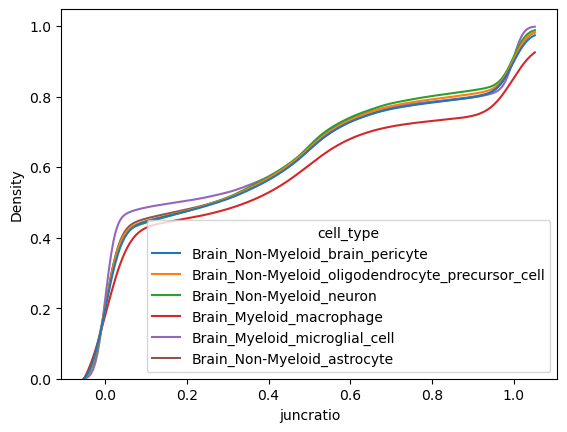

In [7]:
simple_data = final_data[["cell_id_index", "Cluster", "cell_type", "junction_id_index", "juncratio", "junc_count", "cluster_count",  "junction_id", "gene_id"]]
sns.kdeplot(data=final_data, x="juncratio", hue="cell_type", cumulative=True, common_norm=False, common_grid=True)

### Start with a simple PCA using imputed values 

In [8]:
# make matrix of junctions by cells and fill with juncratio values 
mat = np.zeros((len(final_data.cell_id_index.unique()), len(final_data.junction_id_index.unique())))
mat[final_data.cell_id_index, final_data.junction_id_index] = final_data.juncratio
mat[~(final_data.cell_id_index), ~(final_data.junction_id_index)] = np.nan

# imput nan values using mean of each row (does this make sense?)
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(mat)
mat_imputed = imp.transform(mat)

# run PCA on mat_imputed 
pca = PCA(n_components=10)
pca.fit(mat_imputed)
print(pca.explained_variance_ratio_)

[0.04927477 0.0190331  0.00939198 0.0070001  0.00427344 0.00359139
 0.00292126 0.00275748 0.00230924 0.00220756]


In [9]:
pcs = pca.transform(mat_imputed)
pcs_df = pd.DataFrame(pcs, columns=["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10"])
cell_types_pcs = cell_ids_conversion["cell_type"]

Text(0.5, 1.0, 'PCA of Junction Usage Ratios (imputed matrix)')

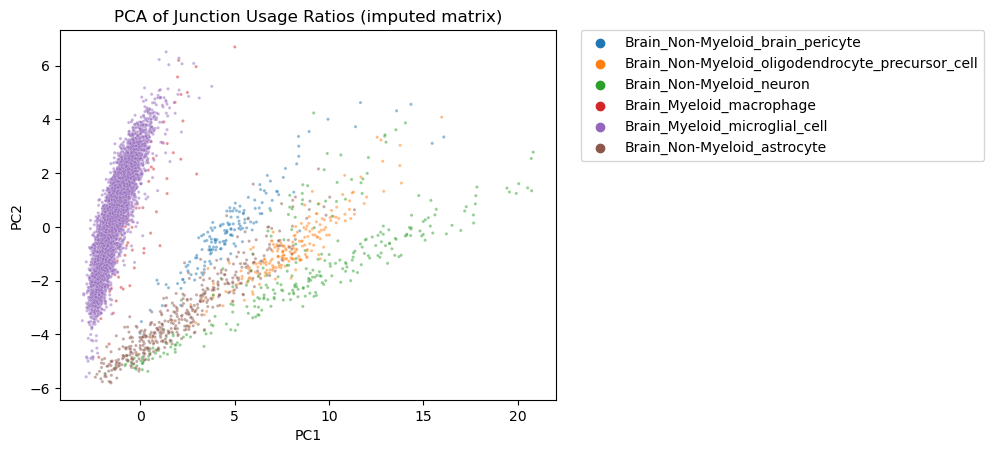

In [10]:
# plot first two PCs
sns.scatterplot(data=pcs_df, x="PC1", y="PC2", hue=cell_types_pcs.values, s=5, alpha=0.5)
# move legend outside of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("PCA of Junction Usage Ratios (imputed matrix)")

Text(0.5, 1.0, 'PCA of Junction Usage Ratios (imputed matrix)')

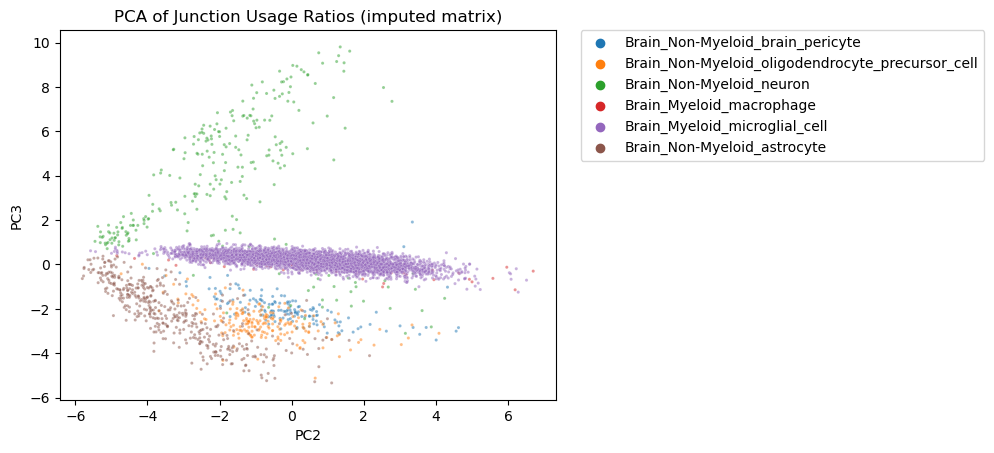

In [11]:
# plot first and third PCs
sns.scatterplot(data=pcs_df, x="PC2", y="PC3", hue=cell_types_pcs.values, s=5, alpha=0.5)
# move legend outside of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("PCA of Junction Usage Ratios (imputed matrix)")

### Take a quick look at coverage of reads across junctions

Text(0.5, 1.0, 'Junction Coverage per Cell (read counts/1000)')

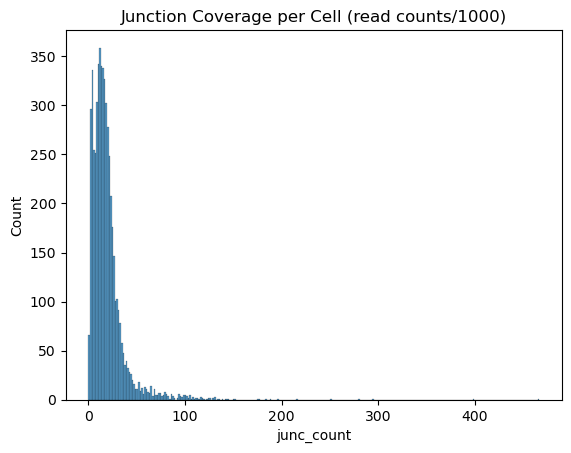

In [12]:
cell_junc_cov = final_data.groupby("cell_id_index").junc_count.sum()
cell_cluster_cov = final_data.groupby("cell_id_index").cluster_count.sum()

# plot histogram of coverage
sns.histplot(cell_junc_cov/1000)
plt.title("Junction Coverage per Cell (read counts/1000)")

Text(0.5, 1.0, 'Cluster Coverage per Cell (read counts/1000)')

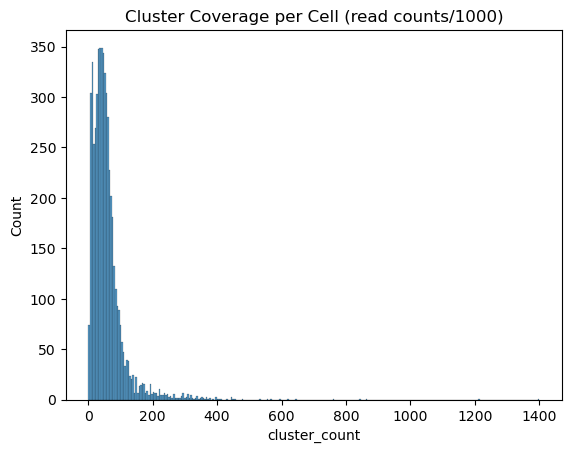

In [13]:
# plot histogram of coverage clusters 
sns.histplot(cell_cluster_cov/1000)
plt.title("Cluster Coverage per Cell (read counts/1000)")

### Get ready for model training 

In [14]:
if device == torch.device('cuda'):
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [15]:
indices = torch.tensor(final_data[['cell_id_index', 'junction_id_index']].to_numpy().T, dtype=torch.long)
values = torch.tensor(final_data['junc_count'].to_numpy(), dtype=torch.float)
# Determine the size of the tensor
num_cells = final_data['cell_id_index'].max() + 1
num_junctions = final_data['junction_id_index'].max() + 1
size = (num_cells, num_junctions)
# Create a sparse tensor
y_tensor = torch.sparse_coo_tensor(indices, values, size)

In [16]:
indices_counts = torch.tensor(final_data[['cell_id_index', 'junction_id_index']].to_numpy().T, dtype=torch.long)
values_counts = torch.tensor(final_data['cluster_count'].to_numpy(), dtype=torch.float)
# Determine the size of the tensor
num_cells_counts = final_data['cell_id_index'].max() + 1
num_junctions_counts = final_data['junction_id_index'].max() + 1
size_counts = (num_cells_counts, num_junctions_counts)
# Create a sparse tensor
total_counts_tensor = torch.sparse_coo_tensor(indices_counts, values_counts, size_counts)

### Run factor model!

Epoch 0, Loss: 155368187.4646382
Epoch 10, Loss: 114942258.22726265
Epoch 20, Loss: 88467664.34351343
Epoch 30, Loss: 71175475.97601914
Epoch 40, Loss: 59825709.27520907
Epoch 50, Loss: 52036946.49279213
Epoch 60, Loss: 46870503.894420624
Epoch 70, Loss: 43394003.70437455
Epoch 80, Loss: 41150278.78617716
Epoch 90, Loss: 39736792.89782643
Epoch 100, Loss: 38781673.72866702
Epoch 110, Loss: 38179419.09438491
Epoch 120, Loss: 37702645.48140955
Epoch 130, Loss: 37365780.348825574
Epoch 140, Loss: 37103031.08725715
Epoch 150, Loss: 36874257.73860836
Epoch 160, Loss: 36689484.43650305
Epoch 170, Loss: 36529555.3111496
Epoch 180, Loss: 36389000.70201743
Epoch 190, Loss: 36276631.88218546


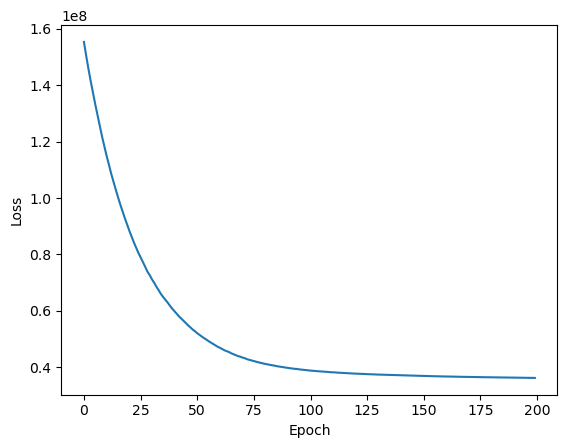

Done! Returning losses, sampled_guide, and latent_vars.


In [17]:
K = 8
losses, sampled_guide, latent_vars = factor_model.main(y_tensor, total_counts_tensor, K, num_epochs=200)

In [18]:
latent_vars

{'_AutoDiagonalNormal_latent': array([ 0.6679081 ,  0.7237734 ,  0.33670026, ..., -2.527311  ,
         1.401267  , -6.4715056 ], dtype=float32),
 'data1': array([   0,    1,    2, ..., 5524, 5525, 5526]),
 'a': array([1.9501535 , 2.0622    , 1.4003192 , ..., 0.37864962, 0.61793   ,
        0.76723444], dtype=float32),
 'b': array([3.1485631 , 1.364516  , 1.1568972 , ..., 1.7100561 , 0.47980013,
        0.55002046], dtype=float32),
 'psi': array([[0.43636054, 0.5444781 , 0.6703655 , ..., 0.01633283, 0.8805866 ,
         0.934453  ],
        [0.50881964, 0.5292492 , 0.480443  , ..., 0.07268416, 0.04083884,
         0.42037186],
        [0.47947   , 0.4208811 , 0.2729785 , ..., 0.7764426 , 0.9795069 ,
         0.98777455],
        ...,
        [0.1646382 , 0.85716146, 0.56645733, ..., 0.02612469, 0.02231798,
         0.06628893],
        [0.41578868, 0.30080947, 0.90880775, ..., 0.22244427, 0.01048486,
         0.9772759 ],
        [0.7039274 , 0.40314168, 0.02416068, ..., 0.02494862, 0.

In [19]:
# extract latent variables
conc = latent_vars["conc"]
assign_post = latent_vars["assign"]
psis = latent_vars["psi"]
a = latent_vars["a"]
b = latent_vars["b"]
pi = latent_vars["pi"]

In [20]:
print("The inferred concentration parameter is: " + str(conc))
print("The inferred pi parameter is: " + str(pi))

The inferred concentration parameter is: 4.9512186
The inferred pi parameter is: [0.6529164  0.04104841 0.05324819 0.04134871 0.0821936  0.04261376
 0.04805073 0.03858023]


In [21]:
assign_post

array([[5.9500390e-01, 6.8124523e-04, 4.1799262e-02, ..., 9.7464785e-05,
        6.4006681e-04, 1.2448657e-04],
       [5.4123986e-01, 1.3880454e-03, 1.5195554e-02, ..., 3.8485741e-05,
        2.2038129e-04, 1.3868492e-06],
       [5.5682892e-01, 8.2872581e-04, 1.9982359e-03, ..., 2.3641462e-05,
        1.0046106e-03, 1.9908143e-04],
       ...,
       [4.5983788e-01, 1.3628287e-03, 1.3555444e-02, ..., 4.3258798e-01,
        3.1336956e-04, 8.8778339e-02],
       [4.7794044e-01, 7.3017244e-04, 1.2402589e-03, ..., 4.2330846e-01,
        2.4119897e-04, 6.0246619e-03],
       [1.7950541e-01, 1.2344633e-02, 1.0799561e-01, ..., 4.5608652e-01,
        3.4697982e-04, 2.2430728e-01]], dtype=float32)

### Evaluate latent variables 

In [22]:
color_palette = sns.color_palette("Set1", n_colors=len(cell_ids_conversion['cell_type'].unique()))
# Create a color bar legend
legend = sns.color_palette(palette=color_palette, as_cmap=True)

# Obtain cell type labels for every cell in the matrix also 
unique_cell_types = cell_ids_conversion['cell_type'].unique()
num_unique_types = len(unique_cell_types)
colors = sns.color_palette('Set1', n_colors=num_unique_types)  # You can use any color palette
cell_types = cell_ids_conversion.cell_type.values

# create colours for each cell type 
cell_type_colors = {cell_type: color for cell_type, color in zip(unique_cell_types, colors)}
row_colors = [cell_type_colors[cell_type] for cell_type in cell_types]

In [23]:
assign_post.shape

(5527, 8)

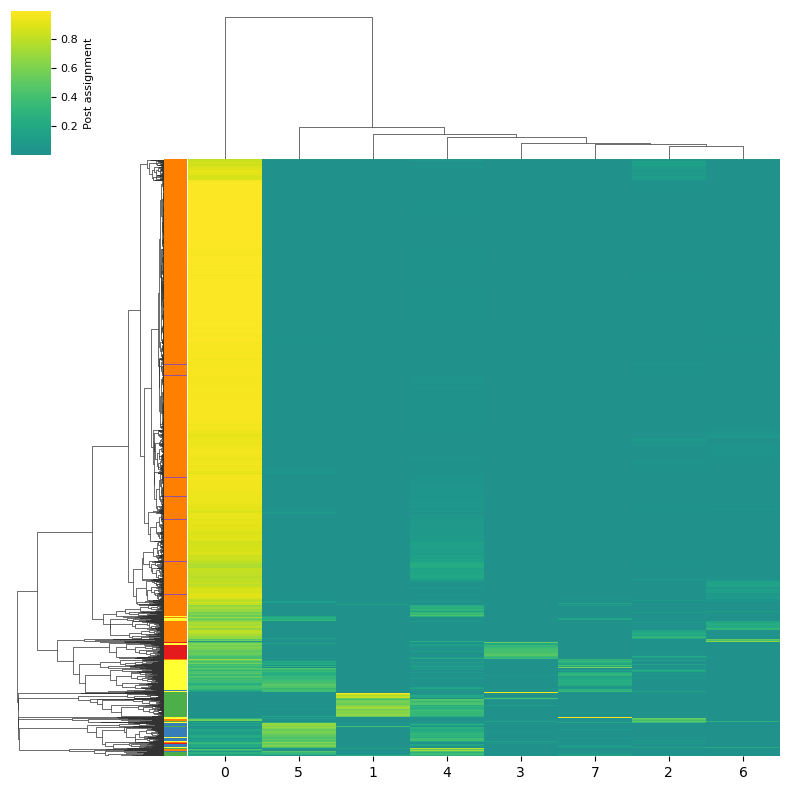

In [24]:
cluster = sns.clustermap(
    data=assign_post,
    method='complete',
    cmap="viridis",
    annot=False,
    fmt=".2f",
    yticklabels=False,
    figsize=(8, 8),
    center=0,
    row_colors=row_colors,  # Apply row colors
    cbar_kws={'label': 'Post assignment'} 
    )
cluster.cax.set_ylabel('Post assignment', size=8)
# Increase font size for color bar tick labels:
cbar_ax = cluster.cax
for label in cbar_ax.yaxis.get_ticklabels():
    label.set_size(8)

Text(0.5, 0, 'Cell Type')

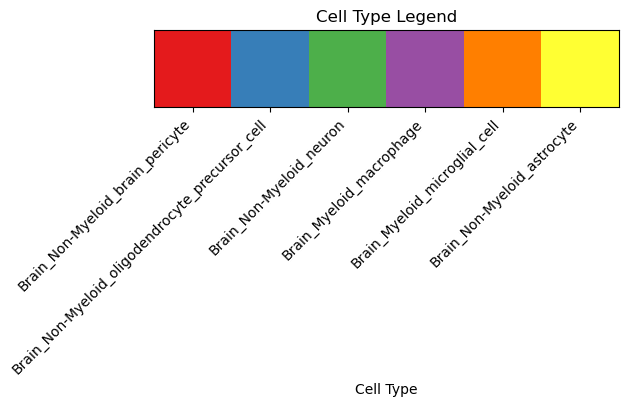

In [25]:
# print cell type color legend seperately
cell_type_colors
# Create a color bar legend
legend = sns.color_palette(palette=color_palette, as_cmap=True)
sns.palplot(color_palette)
plt.title("Cell Type Legend")
# add cell type names to legend
plt.xticks(np.arange(len(unique_cell_types)), unique_cell_types, rotation=45, ha='right')
plt.xlabel("Cell Type")


In [ ]:
# first do k-means clustering on the latent variables
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6, random_state=0).fit(assign_post)
kmeans.labels_

In [28]:
# let's calculate silhouette score ussing assign_post
silhouette_score(assign_post*10, cell_types)

0.23083942